In [0]:
# for some basic operations
import numpy as np 
import pandas as pd 
import datetime
import calendar

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1gXJhtcrcZ-7jFsRfTZXXFcVBKlRA-5qD' # The shareable link

fluff, id = link.split('=')

print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fogo-cruzado.csv') 


1gXJhtcrcZ-7jFsRfTZXXFcVBKlRA-5qD


In [0]:
tiroteios_df = pd.read_csv('fogo-cruzado.csv', encoding='latin-1')

In [0]:
tiroteios_df['data_ocorrencia'] = pd.to_datetime(tiroteios_df['data_ocorrencia'], errors='coerce', dayfirst=True)
tiroteios_df['ano'], tiroteios_df['mes'], tiroteios_df['dia'] = tiroteios_df['data_ocorrencia'].dt.year, tiroteios_df['data_ocorrencia'].dt.month, tiroteios_df['data_ocorrencia'].dt.day

In [0]:
tmp = []
for i in range(tiroteios_df.shape[0]):
    tmp.append(calendar.day_name[datetime.datetime(tiroteios_df['ano'][i], tiroteios_df['mes'][i], tiroteios_df['dia'][i]).weekday()])

tiroteios_df['dia_da_semana'] = tmp
tiroteios_df.head()

,id_ocorrencia,local_ocorrencia,latitude_ocorrencia,longitude_ocorrencia,data_ocorrencia,hora_ocorrencia,presen_agen_segur_ocorrencia,qtd_morto_civil_ocorrencia,qtd_morto_agen_segur_ocorrencia,qtd_ferido_civil_ocorrencia,qtd_ferido_agen_segur_ocorrencia,fonte_ocorrencia,estado_id,cidade_id,nome_cidade,cod_ibge_cidade,gentilico_cidade,populacao_cidade,area_cidade,densidade_demo_cidade,nome_estado,uf_estado,cod_ibge_estado,ano,mes,dia,dia_da_semana
0,8758,Maré; Rio de Janeiro - RJ; Brasil,-22.857496,-43.243015,2018-01-09,15:57:00,0,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2018,1,9,Tuesday
1,10431,R. Alice - Laranjeiras; Rio de Janeiro - RJ; B...,-22.935377,-43.194631,2018-01-19,20:54:00,0,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2018,1,19,Friday
2,10430,Areia Branca; Belford Roxo - RJ; Brasil,-22.748600,-43.410628,2018-01-19,18:37:00,0,0,0,0,0,0,19,3602,Belford Roxo,3300456,belford-roxense,469332,7782,6.03,Rio de Janeiro,RJ,33,2018,1,19,Friday
3,16,Santa Cruz; Rio de Janeiro - RJ; Brasil,-22.919651,-43.684387,2016-07-05,6:02:00,1,0,1,0,0,1,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2016,7,5,Tuesday
4,17,Rua Barão - Praça Seca; Rio de Janeiro - RJ; B...,-22.898642,-43.352360,2016-07-05,13:44:00,1,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2016,7,5,Tuesday


**Contando a frequência dos crimes**

In [0]:
tiroteios_f = tiroteios_df.groupby('nome_cidade')['data_ocorrencia'].count()
tiroteios_f = tiroteios_f.reset_index()
tiroteios_f.columns = ['nome_cidade', 'Frequency']
tiroteios_f.head()

,nome_cidade,Frequency
0,Belford Roxo,1394
1,Cachoeiras de Macacu,2
2,Duque de Caxias,1064
3,Guapimirim,18
4,Itaboraí,294


**Diferença de tempo entre o ultimo tiroteio (verifica basicamente há quanto tempo não tem tiroteio naquela cidade)**

In [0]:
tiroteios_df['data_ocorrencia'] = pd.to_datetime(tiroteios_df['data_ocorrencia'],format='%Y-%m-%d')

In [0]:
max_date = max(tiroteios_df['data_ocorrencia'])
max_date

Timestamp('2019-10-19 00:00:00')

In [0]:
tiroteios_df['Diff'] = max_date - tiroteios_df['data_ocorrencia']
tiroteios_df.head()

,id_ocorrencia,local_ocorrencia,latitude_ocorrencia,longitude_ocorrencia,data_ocorrencia,hora_ocorrencia,presen_agen_segur_ocorrencia,qtd_morto_civil_ocorrencia,qtd_morto_agen_segur_ocorrencia,qtd_ferido_civil_ocorrencia,qtd_ferido_agen_segur_ocorrencia,fonte_ocorrencia,estado_id,cidade_id,nome_cidade,cod_ibge_cidade,gentilico_cidade,populacao_cidade,area_cidade,densidade_demo_cidade,nome_estado,uf_estado,cod_ibge_estado,ano,mes,dia,dia_da_semana,Diff
0,8758,Maré; Rio de Janeiro - RJ; Brasil,-22.857496,-43.243015,2018-01-09,15:57:00,0,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2018,1,9,Tuesday,648 days
1,10431,R. Alice - Laranjeiras; Rio de Janeiro - RJ; B...,-22.935377,-43.194631,2018-01-19,20:54:00,0,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2018,1,19,Friday,638 days
2,10430,Areia Branca; Belford Roxo - RJ; Brasil,-22.748600,-43.410628,2018-01-19,18:37:00,0,0,0,0,0,0,19,3602,Belford Roxo,3300456,belford-roxense,469332,7782,6.03,Rio de Janeiro,RJ,33,2018,1,19,Friday,638 days
3,16,Santa Cruz; Rio de Janeiro - RJ; Brasil,-22.919651,-43.684387,2016-07-05,6:02:00,1,0,1,0,0,1,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2016,7,5,Tuesday,1201 days
4,17,Rua Barão - Praça Seca; Rio de Janeiro - RJ; B...,-22.898642,-43.352360,2016-07-05,13:44:00,1,0,0,0,0,0,19,3661,Rio de Janeiro,3304557,carioca,6320446,119746,5.27,Rio de Janeiro,RJ,33,2016,7,5,Tuesday,1201 days


In [0]:
tiroteios_diff = tiroteios_df.groupby('nome_cidade')['Diff'].min()
tiroteios_diff = tiroteios_diff.reset_index()
tiroteios_diff.head()

,nome_cidade,Diff
0,Belford Roxo,1 days
1,Cachoeiras de Macacu,413 days
2,Duque de Caxias,3 days
3,Guapimirim,111 days
4,Itaboraí,17 days


In [0]:
tiroteios_diff['Diff'] =tiroteios_diff['Diff'].dt.days
tiroteios_diff.head()

,nome_cidade,Diff
0,Belford Roxo,1
1,Cachoeiras de Macacu,413
2,Duque de Caxias,3
3,Guapimirim,111
4,Itaboraí,17


Juntando tudo

In [0]:
tiroteios = pd.merge(tiroteios_f, tiroteios_diff, on='nome_cidade', how='inner')
tiroteios.columns = ['nome_cidade', 'Frequency', 'Recency']
tiroteios.head()

,nome_cidade,Frequency,Recency
0,Belford Roxo,1394,1
1,Cachoeiras de Macacu,2,413
2,Duque de Caxias,1064,3
3,Guapimirim,18,111
4,Itaboraí,294,17


**Verificando outliers**

Text(0.5, 0, 'Atributos')

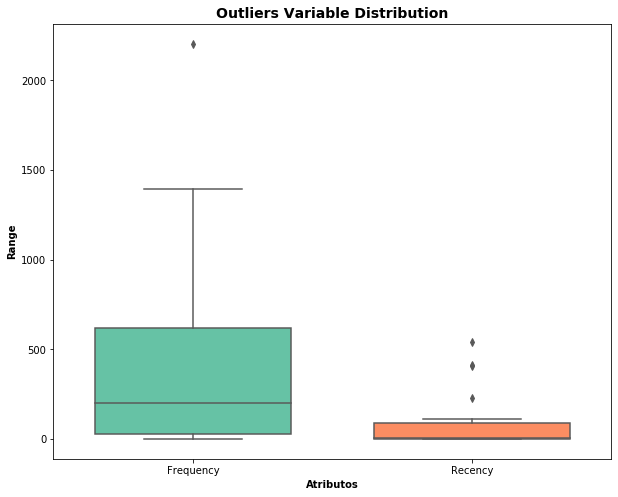

In [0]:
attributes = ['Frequency','Recency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = tiroteios[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)

plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

**Removendo outliers**

In [0]:
Q1 = tiroteios.Recency.quantile(0.05)
Q3 = tiroteios.Recency.quantile(0.95)
IQR = Q3 - Q1
tiroteios = tiroteios[(tiroteios.Recency >= Q1 - 1.5*IQR) & (tiroteios.Recency <= Q3 + 1.5*IQR)]

Q1 = tiroteios.Frequency.quantile(0.05)
Q3 = tiroteios.Frequency.quantile(0.95)
IQR = Q3 - Q1
tiroteios = tiroteios[(tiroteios.Frequency >= Q1 - 1.5*IQR) & (tiroteios.Frequency <= Q3 + 1.5*IQR)]

**Reescalonando os Atributos**
É importante redimensionar as variáveis para que elas tenham uma escala comparável. Existem duas maneiras comuns de redimensionar:

* Escala Mínima-Máxima
* Padronização (média-0, sigma-1)

Aqui, usaremos o escalonamento de padronização.

In [0]:
tmp_data = tiroteios[['Frequency', 'Recency']]

scaler = StandardScaler()

tiroteios_scaled = scaler.fit_transform(tmp_data)
tiroteios_scaled.shape

(20, 2)

In [0]:
tiroteios_scaled = pd.DataFrame(tiroteios_scaled)
tiroteios_scaled.columns = ['Frequency', 'Recency']
tiroteios_scaled.head()

,Frequency,Recency
0,1.602364,-0.580360
1,-0.759943,1.967411
2,1.042334,-0.567992
3,-0.732790,0.099870
4,-0.264402,-0.481417


## K-Means

**K-Means Clustering**
O agrupamento K-means é um dos algoritmos de aprendizado de máquina não supervisionados.

O algoritmo funciona da seguinte maneira:

* O objetivo desse algoritmo é encontrar similaridades entre os dados e agrupá-los conforme o número de cluster passado pelo argumento k.

* Este utiliza um método simples e eficiente baseado no conceito de distância.

* O algoritmo de forma iterativa atribui os pontos de dados ao grupo que representa a menor distância, ou seja, ao grupo de dados que seja mais similar.

In [0]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(tiroteios_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**Encontrando numero ideal de clusters com Elbow-Curve**



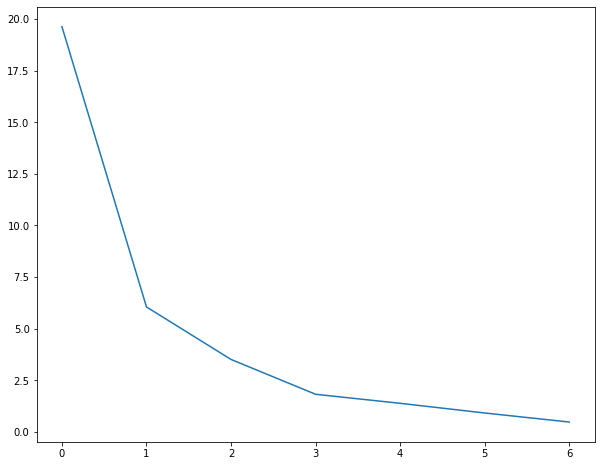

In [0]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(tiroteios_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

**Análise de Silhueta**  
O coeficiente de silhueta avalia a coesão dos clusters através da proximidade de um ponto xi aos pontos xj do cluster Ci onde pertence e a proximidade do mesmo ponto aos pontos do cluster mais próximo Cj . 

O valor deste coeficiente varia entre [−1, 1]:

* o valor 1 significa que xi está mais próximo dos pontos do seu cluster do que dos pontos do cluster mais próximo e −1 representa a situação contrária. 

Por fim, de modo a perceber se os cluster estão bem coesos, faz-se uma média dos coeficientes de silhueta de todos os pontos.

In [0]:
# de 2 a 8 cluters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(tiroteios_scaled)
    
    cluster_labels = kmeans.labels_
    
    # calculo do score de silhueta
    silhouette_avg = silhouette_score(tiroteios_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5698528091914731
For n_clusters=3, the silhouette score is 0.6432777341652172
For n_clusters=4, the silhouette score is 0.630558233445076
For n_clusters=5, the silhouette score is 0.5860419093140548
For n_clusters=6, the silhouette score is 0.5516918704252779
For n_clusters=7, the silhouette score is 0.5271606450944439
For n_clusters=8, the silhouette score is 0.5390469239221526


**Usando k = 3**

In [0]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(tiroteios_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
 kmeans.labels_

array([1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0],
      dtype=int32)

In [0]:
# assign the label
tiroteios['Cluster_Id'] = kmeans.labels_
tiroteios

,nome_cidade,Frequency,Recency,Cluster_Id,Cluster_Labels
0,Belford Roxo,1394,1,1,0
1,Cachoeiras de Macacu,2,413,0,1
2,Duque de Caxias,1064,3,1,0
3,Guapimirim,18,111,2,2
4,Itaboraí,294,17,2,2
5,Itaguaí,199,5,2,2
6,Japeri,207,35,2,2
7,Magé,86,2,2,2
8,Maricá,114,7,2,2
9,Mesquita,249,25,2,2


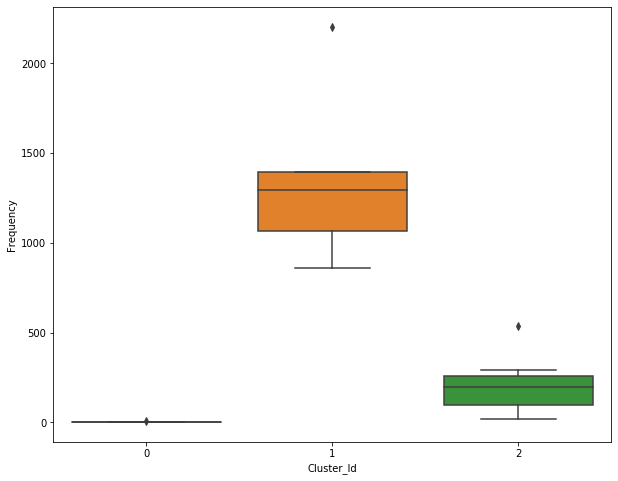

In [0]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=tiroteios)

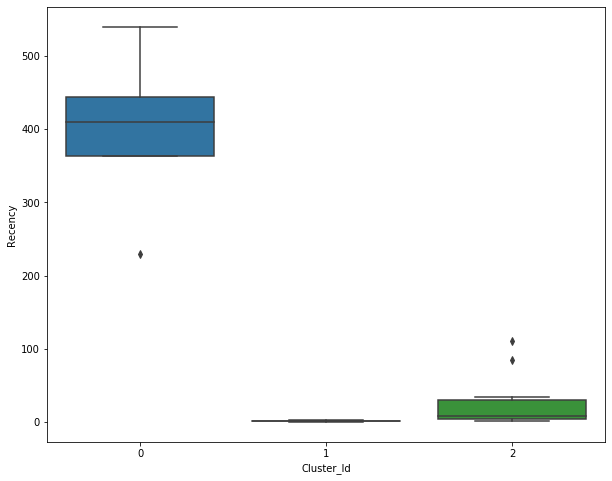

In [0]:
sns.boxplot(x='Cluster_Id', y='Recency', data=tiroteios)

### Cluestering Hierárquico

**Single Linkage**

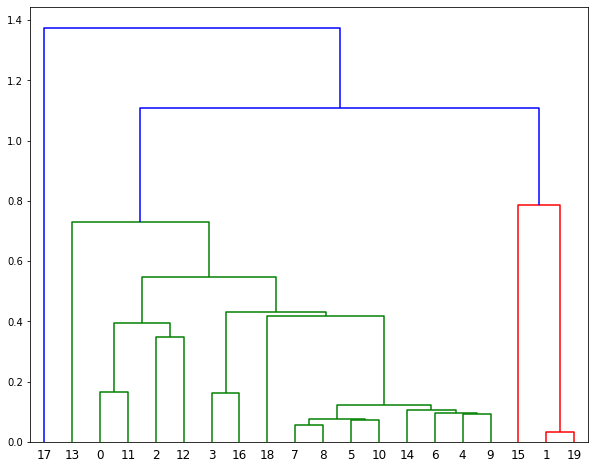

In [0]:
mergings = linkage(tiroteios_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage**

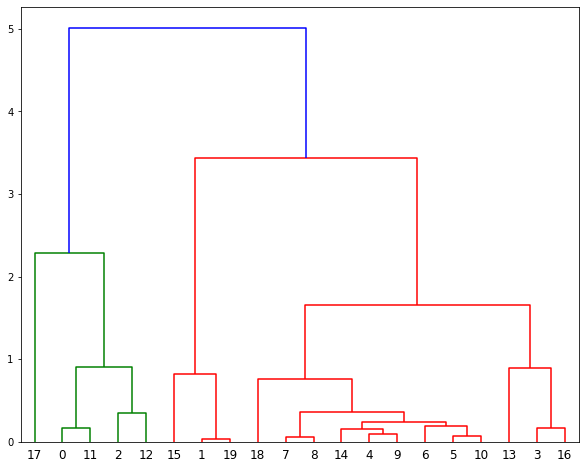

In [0]:
mergings = linkage(tiroteios_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

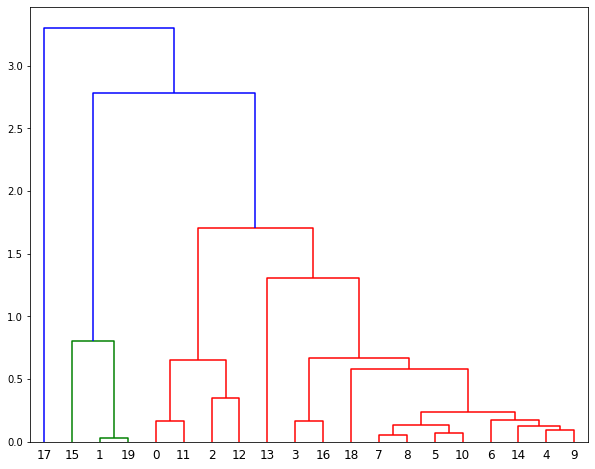

In [0]:
mergings = linkage(tiroteios_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

Cortando o dendograma em k=3

In [0]:
mergings = linkage(tiroteios_scaled, method="complete", metric='euclidean')

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1])

In [0]:
tiroteios['Cluster_Labels'] = cluster_labels
tiroteios

,nome_cidade,Frequency,Recency,Cluster_Id,Cluster_Labels
0,Belford Roxo,1394,1,1,0
1,Cachoeiras de Macacu,2,413,0,1
2,Duque de Caxias,1064,3,1,0
3,Guapimirim,18,111,2,2
4,Itaboraí,294,17,2,2
5,Itaguaí,199,5,2,2
6,Japeri,207,35,2,2
7,Magé,86,2,2,2
8,Maricá,114,7,2,2
9,Mesquita,249,25,2,2


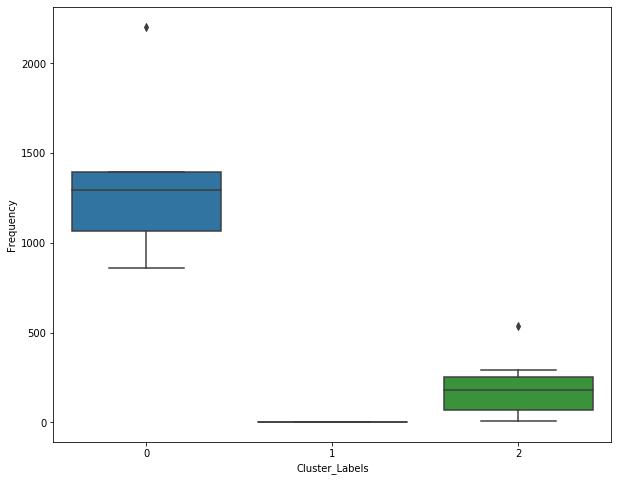

In [0]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=tiroteios)

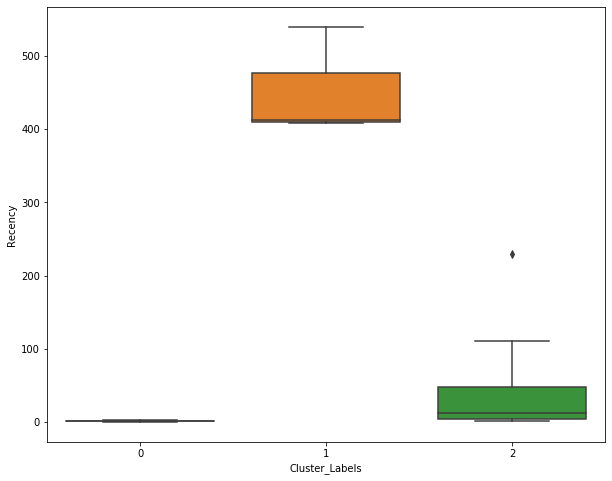

In [0]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=tiroteios)

### Análise Final



* Cluster 0 - Cidades com mais tiroteios sendo estes mais recentes
* Cluster 1 - Cidades com menos tiroteios sendo estes mais antigos
* Cluster 2 - Intermediário

K-means muda o nome do cluster toda vez que é executado. Mas parece que os clusters gerados pelo K-means e dendrograma são praticamente iguais (pouquissima diferença), só muda o nome mesmo.

*De acordo com o professor não tem nenhum agrupamento evidente.*